In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 분리
from sklearn.model_selection import train_test_split
# 사이킷런 내장 데이터셋
from sklearn.datasets import load_iris, load_boston
# K-Fold
from sklearn.model_selection import KFold
# 평가지표 구하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
# 모델 생성
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# 데이터스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss

### 데이터 읽기

In [6]:
cust_tr = pd.read_csv('../Dataset/cust_train.csv', encoding = 'utf-8') # 회원
product_tr = pd.read_csv('../Dataset/product_train.csv',encoding = 'utf-8') # 상품구매
search_tr = pd.read_csv('../Dataset/search_train.csv',encoding = 'utf-8') # 검색어
session_tr = pd.read_csv('../Dataset/session_train.csv',encoding = 'utf-8') # 세션

In [7]:
cust_te = pd.read_csv('../Dataset/sample_submission.csv', encoding = 'utf-8')
product_te = pd.read_csv('../Dataset/product_test.csv',encoding = 'utf-8')
search_te = pd.read_csv('../Dataset/search_test.csv',encoding = 'utf-8')
session_te = pd.read_csv('../Dataset/session_test.csv',encoding = 'utf-8')

In [8]:
master = pd.read_csv('../Dataset/master.csv', encoding = 'utf-8') # 상품분류

### 약간의 전처리

In [9]:
train = pd.merge(product_tr, session_tr, on = ['CLNT_ID','SESS_ID'])
train = pd.merge(train, search_tr, on = ['CLNT_ID','SESS_ID'])
train = pd.merge(train, master, on = 'PD_C')

In [10]:
test = pd.merge(product_te, session_te, on = ['CLNT_ID','SESS_ID'])
test = pd.merge(test, search_te, on = ['CLNT_ID','SESS_ID'])
test = pd.merge(test, master, on = 'PD_C')

In [11]:
train['PD_BUY_AM'] = train['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
train['PD_BUY_CT'] = train['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )
test['PD_BUY_AM'] = test['PD_BUY_AM'].map(lambda x: int(str(x).replace(',','')) )
test['PD_BUY_CT'] = test['PD_BUY_CT'].map(lambda x: int(str(x).replace(',','')) )
train['TOT_SESS_HR_V'] = train['TOT_SESS_HR_V'].str.replace(',', '').astype('int32')
test['TOT_SESS_HR_V'] = test['TOT_SESS_HR_V'].str.replace(',', '').astype('int32')

In [12]:
train['AMOUNT'] = train['PD_BUY_AM'] * train['PD_BUY_CT']
test['AMOUNT'] = test['PD_BUY_AM'] * test['PD_BUY_CT']

In [13]:
train['date'] = pd.to_datetime(train['SESS_DT'], format= '%Y%m%d')
test['date'] = pd.to_datetime(test['SESS_DT'], format= '%Y%m%d')

In [14]:
train.shape, test.shape

((3415963, 23), (1467831, 23))

In [15]:
train.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,KWD_NM,SEARCH_CNT,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM,AMOUNT,date
0,128408,8274151,356,283756,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),42500,1,19,20180515,357.0,4658,mobile,Seoul,Seoul,여아신발,1,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,42500,2018-05-15
1,128408,8274151,356,283756,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),42500,1,19,20180515,357.0,4658,mobile,Seoul,Seoul,아디다스키즈,1,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,42500,2018-05-15
2,128408,8274151,356,283756,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),42500,1,19,20180515,357.0,4658,mobile,Seoul,Seoul,아디다스 바람막이,1,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,42500,2018-05-15
3,128408,8274151,356,283756,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),42500,1,19,20180515,357.0,4658,mobile,Seoul,Seoul,신발,1,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,42500,2018-05-15
4,128408,8274151,356,283756,모델:선택02.CQ2332|사이즈:240 / 1개,아디다스(퍼포먼스),42500,1,19,20180515,357.0,4658,mobile,Seoul,Seoul,여아신발,1,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,42500,2018-05-15


### 약간의 EDA

In [11]:
cust_tr['LABEL'].value_counts()/cust_tr.shape[0]   # 오버샘플링 고려

F30    0.399279
F40    0.346243
F20    0.118181
M40    0.066023
M30    0.053021
M20    0.017252
Name: LABEL, dtype: float64

In [12]:
numeric_columns = train.dtypes[train.dtypes != 'object'].index.tolist()
train[numeric_columns].head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BUY_AM,PD_BUY_CT,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,SEARCH_CNT,AMOUNT,date
0,128408,8274151,356,283756,42500,1,19,20180515,357.0,4658,1,42500,2018-05-15
1,128408,8274151,356,283756,42500,1,19,20180515,357.0,4658,1,42500,2018-05-15
2,128408,8274151,356,283756,42500,1,19,20180515,357.0,4658,1,42500,2018-05-15
3,128408,8274151,356,283756,42500,1,19,20180515,357.0,4658,1,42500,2018-05-15
4,128408,8274151,356,283756,42500,1,19,20180515,357.0,4658,1,42500,2018-05-15


<AxesSubplot:xlabel='PD_BUY_AM', ylabel='Density'>

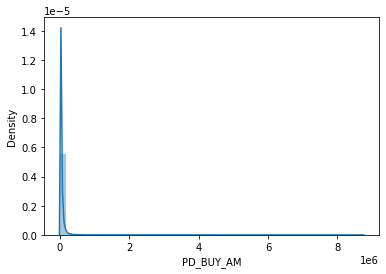

In [13]:
sns.distplot(train['PD_BUY_AM'])

<AxesSubplot:xlabel='AMOUNT', ylabel='Density'>

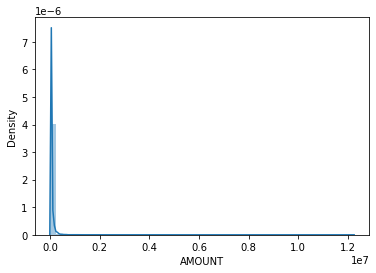

In [14]:
sns.distplot(train['AMOUNT'])

<AxesSubplot:xlabel='TOT_PAG_VIEW_CT', ylabel='Density'>

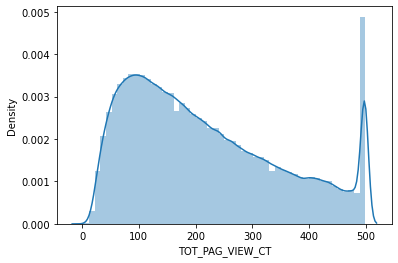

In [15]:
sns.distplot(train['TOT_PAG_VIEW_CT'])

In [16]:
train['TOT_PAG_VIEW_CT'].value_counts()

499.0    67065
498.0    37141
497.0    20573
496.0    14280
110.0    12615
         ...  
7.0         29
5.0         28
4.0         22
3.0          8
2.0          5
Name: TOT_PAG_VIEW_CT, Length: 498, dtype: int64

<AxesSubplot:xlabel='TOT_SESS_HR_V', ylabel='Density'>

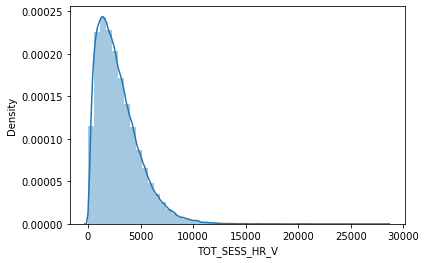

In [17]:
sns.distplot(train['TOT_SESS_HR_V'])

In [18]:
train = train.merge(cust_tr, on='CLNT_ID', how='left')

In [19]:
cond_M20 = train['LABEL'] == 'M20'
cond_M30 = train['LABEL'] == 'M30'
cond_M40 = train['LABEL'] == 'M40'
cond_F20 = train['LABEL'] == 'F20'
cond_F30 = train['LABEL'] == 'F30'
cond_F40 = train['LABEL'] == 'F40'

In [20]:
def show_column_hist_by_target(df, column):    
    cond_M20 = train['LABEL'] == 'M20'
    cond_M30 = train['LABEL'] == 'M30'
    cond_M40 = train['LABEL'] == 'M40'
    cond_F20 = train['LABEL'] == 'F20'
    cond_F30 = train['LABEL'] == 'F30'
    cond_F40 = train['LABEL'] == 'F40'

    fig, axs = plt.subplots(figsize=(20, 10), nrows=2, ncols=3, squeeze=False)
    
    sns.distplot(df[cond_M20][column], ax=axs[0][0], label='M20', color='b')
    sns.distplot(df[cond_M30][column], ax=axs[0][1], label='M30', color='b')
    sns.distplot(df[cond_M40][column], ax=axs[0][2], label='M40', color='b')
    sns.distplot(df[cond_F20][column], ax=axs[1][0], label='F20', color='b')
    sns.distplot(df[cond_F30][column], ax=axs[1][1], label='F30', color='b')
    sns.distplot(df[cond_F40][column], ax=axs[1][2], label='F40', color='b')

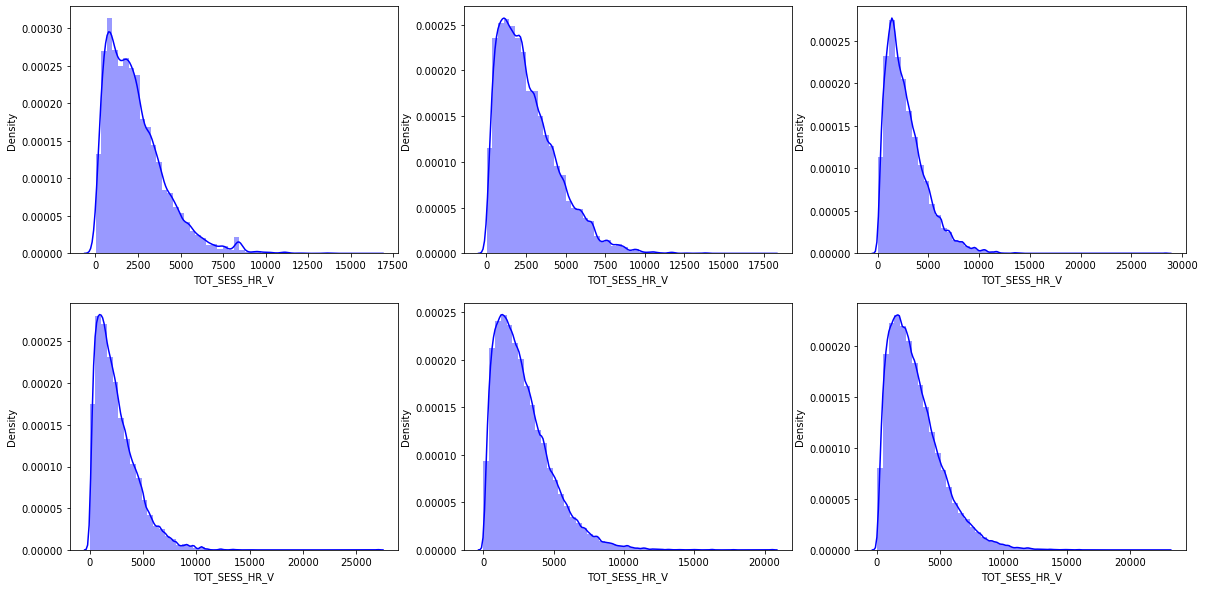

In [21]:
show_column_hist_by_target(train, 'TOT_SESS_HR_V')

In [22]:
object_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
train[object_columns].head()

,PD_ADD_NM,PD_BRA_NM,DVC_CTG_NM,ZON_NM,CITY_NM,KWD_NM,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM,LABEL
0,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),mobile,Seoul,Seoul,여아신발,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,M40
1,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),mobile,Seoul,Seoul,아디다스키즈,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,M40
2,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),mobile,Seoul,Seoul,아디다스 바람막이,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,M40
3,모델:선택02.CQ2332|사이즈:260 / 1개,아디다스(퍼포먼스),mobile,Seoul,Seoul,신발,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,M40
4,모델:선택02.CQ2332|사이즈:240 / 1개,아디다스(퍼포먼스),mobile,Seoul,Seoul,여아신발,니짜 6종 택1 (CQ2333 CQ2332 CQ2331 CQ2537 CQ3104 C...,스포츠패션,여성스포츠화,여성런닝/트레이닝화,M40


In [23]:
train.groupby('CLNT_ID')['PD_ADD_NM'].nunique()

CLNT_ID
0          2
1          4
2          3
3          2
4          3
          ..
263099    16
263100     2
263101     2
263102     3
263103     6
Name: PD_ADD_NM, Length: 263104, dtype: int64

### 이상치 확인

In [24]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [25]:
get_outlier(df=train, column='PD_BUY_AM', weight=1.5)

Int64Index([   2813,    2814,    2815,    2816,    3323,    3324,    3325,
               3326,    3327,    3328,
            ...
            3411222, 3411227, 3411230, 3411239, 3411244, 3411264, 3411287,
            3411298, 3411299, 3411300],
           dtype='int64', length=256219)

In [26]:
get_outlier(df=train, column='AMOUNT', weight=1.5)

Int64Index([   2813,    2814,    2815,    2816,    3323,    3324,    3325,
               3326,    3327,    3328,
            ...
            3411264, 3411287, 3411298, 3411299, 3411300, 3414249, 3415042,
            3415193, 3415194, 3415698],
           dtype='int64', length=260747)

In [27]:
# 이상치가 상당히 많음
# 극단적인 이상치값만 제외하기로 결정
train[['PD_BUY_AM', 'AMOUNT']].describe()

,PD_BUY_AM,AMOUNT
count,3.415963e+06,3.415963e+06
mean,4.395779e+04,4.526175e+04
std,8.760473e+04,9.164452e+04
min,9.000000e+01,1.000000e+02
25%,1.260000e+04,1.360000e+04
50%,2.700000e+04,2.800000e+04
75%,4.721500e+04,4.880000e+04
max,8.745000e+06,1.223400e+07


In [28]:
# 'PD_BUY_AM', 'AMOUNT' 칼럼을 로그변환해주면 아아아주 좋을 것 같음!

<AxesSubplot:>

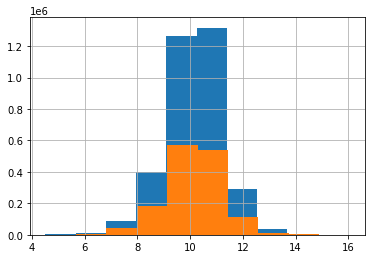

In [29]:
train['PD_BUY_AM_log'] = np.log1p(train['PD_BUY_AM'])
train['PD_BUY_AM_log'].hist()
test['PD_BUY_AM_log'] = np.log1p(test['PD_BUY_AM'])
test['PD_BUY_AM_log'].hist()

<AxesSubplot:>

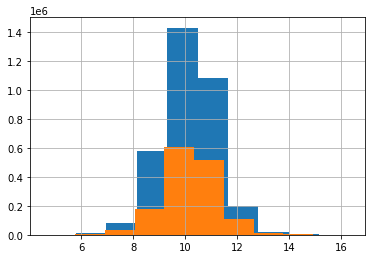

In [30]:
train['AMOUNT_log'] = np.log1p(train['AMOUNT'])
train['AMOUNT_log'].hist()
test['AMOUNT_log'] = np.log1p(test['AMOUNT'])
test['AMOUNT_log'].hist()

In [31]:
train['TOT_SESS_HR_V_log'] = np.log1p(train['TOT_SESS_HR_V'])
test['TOT_SESS_HR_V_log'] = np.log1p(test['TOT_SESS_HR_V'])

<AxesSubplot:>

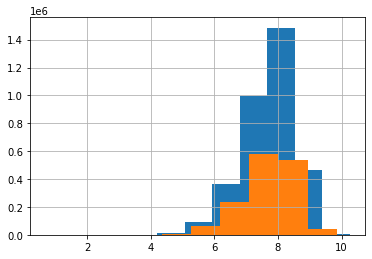

In [32]:
train['TOT_SESS_HR_V_log'].hist()
test['TOT_SESS_HR_V_log'].hist()

In [33]:
train[['SEARCH_CNT', 'KWD_NM']]

,SEARCH_CNT,KWD_NM
0,1,여아신발
1,1,아디다스키즈
2,1,아디다스 바람막이
3,1,신발
4,1,여아신발
...,...,...
3415958,1,에잇세컨즈
3415959,1,쿠폰
3415960,1,올리비아로렌
3415961,1,올리비아로렌


### 피처를 만들어보자

In [34]:
features = []
features_te = []

### numeric 변수

#### agg 적용

In [35]:
train['TOP_PAG_VIEW_RATIO'] = train['TOT_SESS_HR_V'] / train['TOT_PAG_VIEW_CT']
test['TOP_PAG_VIEW_RATIO'] = test['TOT_SESS_HR_V'] / test['TOT_PAG_VIEW_CT']

In [36]:
agg_dict = {
    # 기존 컬럼
    'CLNT_ID':['count'],
    'PD_BUY_AM':['min', 'max', 'mean'],
    'AMOUNT':['min', 'max', 'mean', 'size'],
    'TOT_PAG_VIEW_CT':['min', 'max', 'mean', 'sum'],
    'TOT_SESS_HR_V':['min', 'max', 'mean', 'sum'],
    'SEARCH_CNT':['mean', 'sum', 'max'],
    'PD_BRA_NM':['count', 'nunique'],
    'KWD_NM':['nunique', 'count'],
    'SESS_ID':['size'],
    'PD_C':['nunique', 'count'],
    'PD_BUY_CT':['sum', 'mean'],
    'SESS_ID':['count'],
    'SESS_SEQ':['count'],
    'SESS_DT':['count'],
    'CLAC1_NM':['count'],
    'CLAC2_NM':['count'],
    'CLAC3_NM':['count'],
    'PD_ADD_NM':['nunique'],
    
    # 추가 가공 컬럼
    'PD_BUY_AM_log':['min', 'max', 'mean'],
    'AMOUNT_log':['min', 'max', 'mean'],
    'TOT_SESS_HR_V_log':['min', 'max', 'mean'],
    'TOP_PAG_VIEW_RATIO':['mean', 'max', 'sum']
}

In [37]:
f = train.groupby('CLNT_ID').agg(agg_dict)
f.columns = [('_').join(column).upper() for column in f.columns.ravel()]
f = f.reset_index()
f['KWD_NM_RATIO'] = f['SEARCH_CNT_SUM'] / f['KWD_NM_COUNT']
f['PD_ADD_NM_RATIO'] = f['CLNT_ID_COUNT'] / f['PD_ADD_NM_NUNIQUE']
features.append(f); display(f)

,CLNT_ID,CLNT_ID_COUNT,PD_BUY_AM_MIN,PD_BUY_AM_MAX,PD_BUY_AM_MEAN,AMOUNT_MIN,AMOUNT_MAX,AMOUNT_MEAN,AMOUNT_SIZE,TOT_PAG_VIEW_CT_MIN,TOT_PAG_VIEW_CT_MAX,TOT_PAG_VIEW_CT_MEAN,TOT_PAG_VIEW_CT_SUM,TOT_SESS_HR_V_MIN,TOT_SESS_HR_V_MAX,TOT_SESS_HR_V_MEAN,TOT_SESS_HR_V_SUM,SEARCH_CNT_MEAN,SEARCH_CNT_SUM,SEARCH_CNT_MAX,PD_BRA_NM_COUNT,PD_BRA_NM_NUNIQUE,KWD_NM_NUNIQUE,KWD_NM_COUNT,SESS_ID_COUNT,PD_C_NUNIQUE,PD_C_COUNT,PD_BUY_CT_SUM,PD_BUY_CT_MEAN,SESS_SEQ_COUNT,SESS_DT_COUNT,CLAC1_NM_COUNT,CLAC2_NM_COUNT,CLAC3_NM_COUNT,PD_ADD_NM_NUNIQUE,PD_BUY_AM_LOG_MIN,PD_BUY_AM_LOG_MAX,PD_BUY_AM_LOG_MEAN,AMOUNT_LOG_MIN,AMOUNT_LOG_MAX,AMOUNT_LOG_MEAN,TOT_SESS_HR_V_LOG_MIN,TOT_SESS_HR_V_LOG_MAX,TOT_SESS_HR_V_LOG_MEAN,TOP_PAG_VIEW_RATIO_MEAN,TOP_PAG_VIEW_RATIO_MAX,TOP_PAG_VIEW_RATIO_SUM,KWD_NM_RATIO,PD_ADD_NM_RATIO
0,0,2,5500,81000,43250.000000,5500,81000,43250.000000,2,59.0,59.0,59.000000,118.0,922,922,922.000000,1844,1.000000,2,1,2,2,1,2,2,2,2,2,1.000000,2,2,2,2,2,2,8.612685,11.302217,9.957451,8.612685,11.302217,9.957451,6.827629,6.827629,6.827629,15.627119,15.627119,31.254237,1.000000,1.000000
1,1,16,39000,99000,79750.000000,39000,99000,79750.000000,16,102.0,161.0,127.812500,2045.0,620,3063,1385.000000,22160,1.437500,23,2,16,5,9,16,16,8,16,16,1.000000,16,16,16,16,16,4,10.571343,11.502885,11.239377,10.571343,11.502885,11.239377,6.431331,8.027477,7.068605,10.575642,23.204545,169.210265,1.437500,4.000000
2,2,11,10000,62100,50000.000000,20000,62100,50909.090909,11,66.0,284.0,264.181818,2906.0,371,4787,4385.545455,48241,2.090909,23,3,11,3,6,11,11,3,11,12,1.090909,11,11,11,11,11,3,9.210440,11.036517,10.733113,9.903538,11.036517,10.796121,5.918894,8.473868,8.241598,15.834323,16.855634,174.177550,2.090909,3.666667
3,3,8,102400,110400,106400.000000,102400,110400,106400.000000,8,93.0,93.0,93.000000,744.0,1051,1051,1051.000000,8408,1.500000,12,3,8,2,4,8,8,2,8,8,1.000000,8,8,8,8,8,2,11.536652,11.611874,11.574263,11.536652,11.611874,11.574263,6.958448,6.958448,6.958448,11.301075,11.301075,90.408602,1.500000,4.000000
4,4,6,12800,37000,20866.666667,12800,37000,20866.666667,6,54.0,62.0,56.666667,340.0,515,792,699.666667,4198,1.833333,11,2,6,2,4,6,6,2,6,6,1.000000,6,6,6,6,6,3,9.457279,10.518700,9.811086,9.457279,10.518700,9.811086,6.246107,6.675823,6.532584,12.546595,14.666667,75.279570,1.833333,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,112,7000,22000,8687.500000,7000,22000,8687.500000,112,274.0,274.0,274.000000,30688.0,3890,3890,3890.000000,435680,1.142857,128,2,112,1,7,112,112,4,112,112,1.000000,112,112,112,112,112,16,8.853808,9.998843,9.002745,8.853808,9.998843,9.002745,8.266421,8.266421,8.266421,14.197080,14.197080,1590.072993,1.142857,7.000000
263100,263100,2,9500,12900,11200.000000,9500,12900,11200.000000,2,52.0,156.0,104.000000,208.0,452,2497,1474.500000,2949,1.000000,2,1,2,2,2,2,2,2,2,2,1.000000,2,2,2,2,2,2,9.159152,9.465060,9.312106,9.159152,9.465060,9.312106,6.115892,7.823246,6.969569,12.349359,16.006410,24.698718,1.000000,1.000000
263101,263101,4,33900,33900,33900.000000,33900,33900,33900.000000,4,78.0,78.0,78.000000,312.0,1789,1789,1789.000000,7156,1.500000,6,2,4,1,2,4,4,1,4,4,1.000000,4,4,4,4,4,2,10.431200,10.431200,10.431200,10.431200,10.431200,10.431200,7.489971,7.489971,7.489971,22.935897,22.935897,91.743590,1.500000,2.000000
263102,263102,15,1080,1080,1080.000000,1080,9720,3960.000000,15,188.0,188.0,188.000000,2820.0,1812,1812,1812.000000,27180,1.200000,18,2,15,1,5,15,15,1,15,55,3.666667,15,15,15,15,15,3,6.985642,6.985642,6.985642,6.985642,9.182044,7.717776,7.502738,7.502738,7.502738,9.638298,9.638298,144.574468,1.200000,5.000000


In [38]:
f_te = test.groupby('CLNT_ID').agg(agg_dict)
f_te.columns = [('_').join(column).upper() for column in f_te.columns.ravel()]
f_te = f_te.reset_index()
f_te['KWD_NM_RATIO'] = f_te['SEARCH_CNT_SUM'] / f_te['KWD_NM_COUNT']
f_te['PD_ADD_NM_RATIO'] = f_te['CLNT_ID_COUNT'] / f_te['PD_ADD_NM_NUNIQUE']
features_te.append(f_te); display(f_te)

,CLNT_ID,CLNT_ID_COUNT,PD_BUY_AM_MIN,PD_BUY_AM_MAX,PD_BUY_AM_MEAN,AMOUNT_MIN,AMOUNT_MAX,AMOUNT_MEAN,AMOUNT_SIZE,TOT_PAG_VIEW_CT_MIN,TOT_PAG_VIEW_CT_MAX,TOT_PAG_VIEW_CT_MEAN,TOT_PAG_VIEW_CT_SUM,TOT_SESS_HR_V_MIN,TOT_SESS_HR_V_MAX,TOT_SESS_HR_V_MEAN,TOT_SESS_HR_V_SUM,SEARCH_CNT_MEAN,SEARCH_CNT_SUM,SEARCH_CNT_MAX,PD_BRA_NM_COUNT,PD_BRA_NM_NUNIQUE,KWD_NM_NUNIQUE,KWD_NM_COUNT,SESS_ID_COUNT,PD_C_NUNIQUE,PD_C_COUNT,PD_BUY_CT_SUM,PD_BUY_CT_MEAN,SESS_SEQ_COUNT,SESS_DT_COUNT,CLAC1_NM_COUNT,CLAC2_NM_COUNT,CLAC3_NM_COUNT,PD_ADD_NM_NUNIQUE,PD_BUY_AM_LOG_MIN,PD_BUY_AM_LOG_MAX,PD_BUY_AM_LOG_MEAN,AMOUNT_LOG_MIN,AMOUNT_LOG_MAX,AMOUNT_LOG_MEAN,TOT_SESS_HR_V_LOG_MIN,TOT_SESS_HR_V_LOG_MAX,TOT_SESS_HR_V_LOG_MEAN,TOP_PAG_VIEW_RATIO_MEAN,TOP_PAG_VIEW_RATIO_MAX,TOP_PAG_VIEW_RATIO_SUM,KWD_NM_RATIO,PD_ADD_NM_RATIO
0,263104,3,6900,9900,8233.333333,7900,13800,10533.333333,3,44.0,44.0,44.0,132.0,688,688,688.0,2064,1.000000,3,1,3,1,1,3,3,3,3,4,1.333333,3,3,3,3,3,2,8.839422,9.200391,9.004852,8.974745,9.532496,9.235877,6.535241,6.535241,6.535241,15.636364,15.636364,46.909091,1.000000,1.500000
1,263105,4,37000,120000,78500.000000,37000,120000,78500.000000,4,167.0,272.0,219.5,878.0,2162,3206,2684.0,10736,6.500000,26,15,4,2,3,4,4,2,4,4,1.000000,4,4,4,4,4,2,10.518700,11.695255,11.106978,10.518700,11.695255,11.106978,7.679251,8.073091,7.876171,13.573067,19.197605,54.292268,6.500000,2.000000
2,263106,2,19900,29900,24900.000000,19900,29900,24900.000000,2,96.0,96.0,96.0,192.0,1825,1825,1825.0,3650,1.000000,2,1,2,1,1,2,2,2,2,2,1.000000,2,2,2,2,2,2,9.898525,10.305647,10.102086,9.898525,10.305647,10.102086,7.509883,7.509883,7.509883,19.010417,19.010417,38.020833,1.000000,1.000000
3,263107,2,39000,49000,44000.000000,39000,49000,44000.000000,2,44.0,100.0,72.0,144.0,392,834,613.0,1226,1.000000,2,1,2,1,1,2,2,2,2,2,1.000000,2,2,2,2,2,2,10.571343,10.799596,10.685469,10.571343,10.799596,10.685469,5.973810,6.727432,6.350621,8.624545,8.909091,17.249091,1.000000,1.000000
4,263108,1,124000,124000,124000.000000,124000,124000,124000.000000,1,90.0,90.0,90.0,90.0,618,618,618.0,618,1.000000,1,1,1,1,1,1,1,1,1,1,1.000000,1,1,1,1,1,1,11.728045,11.728045,11.728045,11.728045,11.728045,11.728045,6.428105,6.428105,6.428105,6.866667,6.866667,6.866667,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,3,20000,35000,26666.666667,20000,35000,26666.666667,3,133.0,133.0,133.0,399.0,1286,1286,1286.0,3858,3.000000,9,3,3,1,1,3,3,3,3,3,1.000000,3,3,3,3,3,1,9.903538,10.463132,10.164447,9.903538,10.463132,10.164447,7.160069,7.160069,7.160069,9.669173,9.669173,29.007519,3.000000,3.000000
112756,375860,12,35400,149000,75233.333333,35400,149000,75233.333333,12,26.0,154.0,80.0,960.0,304,2399,1321.0,15852,1.916667,23,5,12,1,3,12,12,9,12,12,1.000000,12,12,12,12,12,9,10.474495,11.911708,11.117562,10.474495,11.911708,11.117562,5.720312,7.783224,7.051056,17.750960,44.133333,213.011518,1.916667,1.333333
112757,375861,2,45900,45900,45900.000000,45900,45900,45900.000000,2,93.0,93.0,93.0,186.0,1740,1740,1740.0,3480,1.500000,3,2,2,1,2,2,2,1,2,2,1.000000,2,2,2,2,2,1,10.734242,10.734242,10.734242,10.734242,10.734242,10.734242,7.462215,7.462215,7.462215,18.709677,18.709677,37.419355,1.500000,2.000000
112758,375862,4,23000,23000,23000.000000,23000,23000,23000.000000,4,85.0,85.0,85.0,340.0,2146,2146,2146.0,8584,1.000000,4,1,4,1,2,4,4,1,4,4,1.000000,4,4,4,4,4,2,10.043293,10.043293,10.043293,10.043293,10.043293,10.043293,7.671827,7.671827,7.671827,25.247059,25.247059,100.988235,1.000000,2.000000


#### 주말방문비율

In [26]:
f = train.groupby('CLNT_ID')['date'].agg([
    ('주말방문비율', lambda x: np.mean(x.dt.dayofweek>4))]).reset_index()
features.append(f); display(f)

f_te = test.groupby('CLNT_ID')['date'].agg([
    ('주말방문비율', lambda x: np.mean(x.dt.dayofweek>4))]).reset_index()
features_te.append(f_te);display(f_te)

,CLNT_ID,주말방문비율
0,0,1.000000
1,1,0.125000
2,2,0.000000
3,3,1.000000
4,4,0.333333
...,...,...
263099,263099,0.000000
263100,263100,0.500000
263101,263101,0.000000
263102,263102,0.000000


,CLNT_ID,주말방문비율
0,263104,0.00
1,263105,0.50
2,263106,1.00
3,263107,0.00
4,263108,1.00
...,...,...
112755,375859,0.00
112756,375860,0.25
112757,375861,0.00
112758,375862,0.00


#### 계절별 방문비율

In [27]:
f = train.groupby('CLNT_ID')['date'].agg([
    ('봄-구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12])))
]).reset_index()
features.append(f); f

,CLNT_ID,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,0.000000,1.000000,0.000000,0.0
1,1,0.375000,0.625000,0.000000,0.0
2,2,0.000000,0.909091,0.090909,0.0
3,3,0.000000,0.000000,1.000000,0.0
4,4,0.666667,0.333333,0.000000,0.0
...,...,...,...,...,...
263099,263099,0.000000,1.000000,0.000000,0.0
263100,263100,0.500000,0.500000,0.000000,0.0
263101,263101,1.000000,0.000000,0.000000,0.0
263102,263102,1.000000,0.000000,0.000000,0.0


In [28]:
f_te = test.groupby('CLNT_ID')['date'].agg([
    ('봄-구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12])))
]).reset_index()
features_te.append(f_te); f_te

,CLNT_ID,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,263104,0.000000,1.000000,0.0,0.0
1,263105,0.000000,1.000000,0.0,0.0
2,263106,0.000000,1.000000,0.0,0.0
3,263107,1.000000,0.000000,0.0,0.0
4,263108,0.000000,1.000000,0.0,0.0
...,...,...,...,...,...
112755,375859,1.000000,0.000000,0.0,0.0
112756,375860,0.583333,0.416667,0.0,0.0
112757,375861,0.000000,1.000000,0.0,0.0
112758,375862,0.000000,1.000000,0.0,0.0


#### 분기별 방문횟수, 비율

In [29]:
train['quarter'] = train['date'].dt.quarter
test['quarter'] = test['date'].dt.quarter;test['quarter']

0          2
1          3
2          3
3          3
4          3
          ..
1467826    2
1467827    2
1467828    2
1467829    2
1467830    2
Name: quarter, Length: 1467831, dtype: int64

In [30]:
f = train.groupby(['CLNT_ID', 'quarter'])['CLNT_ID'].count().unstack()
f = f.fillna(0)
f.columns = ['Quarter_'+ str(column) for column in f.columns]
f = f.reset_index()
features.append(f); f

,CLNT_ID,Quarter_2,Quarter_3
0,0,2.0,0.0
1,1,16.0,0.0
2,2,10.0,1.0
3,3,0.0,8.0
4,4,4.0,2.0
...,...,...,...
263099,263099,0.0,112.0
263100,263100,2.0,0.0
263101,263101,4.0,0.0
263102,263102,15.0,0.0


In [31]:
f_te = test.groupby(['CLNT_ID', 'quarter'])['CLNT_ID'].count().unstack()
f_te = f_te.fillna(0)
f_te.columns = ['Quarter_'+ str(column) for column in f_te.columns]
f_te = f_te.reset_index()
features_te.append(f_te); f_te

,CLNT_ID,Quarter_2,Quarter_3
0,263104,0.0,3.0
1,263105,4.0,0.0
2,263106,0.0,2.0
3,263107,2.0,0.0
4,263108,1.0,0.0
...,...,...,...
112755,375859,3.0,0.0
112756,375860,10.0,2.0
112757,375861,2.0,0.0
112758,375862,0.0,4.0


In [32]:
f = train.groupby('CLNT_ID')['quarter'].agg([
    ('Quarter_2_ratio', lambda x: np.mean(x.isin([2]))),
    ('Quarter_3_ratio', lambda x: np.mean(x.isin([3])))
]).reset_index()
features.append(f); f

,CLNT_ID,Quarter_2_ratio,Quarter_3_ratio
0,0,1.000000,0.000000
1,1,1.000000,0.000000
2,2,0.909091,0.090909
3,3,0.000000,1.000000
4,4,0.666667,0.333333
...,...,...,...
263099,263099,0.000000,1.000000
263100,263100,1.000000,0.000000
263101,263101,1.000000,0.000000
263102,263102,1.000000,0.000000


In [33]:
f_te = test.groupby('CLNT_ID')['quarter'].agg([
    ('Quarter_2_ratio', lambda x: np.mean(x.isin([2]))),
    ('Quarter_3_ratio', lambda x: np.mean(x.isin([3])))
]).reset_index()
features_te.append(f_te); f_te

,CLNT_ID,Quarter_2_ratio,Quarter_3_ratio
0,263104,0.000000,1.000000
1,263105,1.000000,0.000000
2,263106,0.000000,1.000000
3,263107,1.000000,0.000000
4,263108,1.000000,0.000000
...,...,...,...
112755,375859,1.000000,0.000000
112756,375860,0.833333,0.166667
112757,375861,1.000000,0.000000
112758,375862,0.000000,1.000000


#### 요일별 방문 횟수, 비율

In [34]:
train['weekday'] = train['date'].dt.weekday
test['weekday'] = test['date'].dt.weekday

In [35]:
f = train.groupby(['CLNT_ID', 'weekday'])['CLNT_ID'].count().unstack()
f = f.fillna(0)
f.columns = ['Weekday_'+ str(column) for column in f.columns]
f = f.reset_index()
features.append(f); f

,CLNT_ID,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,1,0.0,11.0,3.0,0.0,0.0,2.0,0.0
2,2,1.0,0.0,0.0,10.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,4,0.0,4.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...
263099,263099,112.0,0.0,0.0,0.0,0.0,0.0,0.0
263100,263100,0.0,1.0,0.0,0.0,0.0,1.0,0.0
263101,263101,0.0,0.0,4.0,0.0,0.0,0.0,0.0
263102,263102,0.0,0.0,0.0,15.0,0.0,0.0,0.0


In [36]:
f_te = test.groupby(['CLNT_ID', 'weekday'])['CLNT_ID'].count().unstack()
f_te = f_te.fillna(0)
f_te.columns = ['Weekday_'+ str(column) for column in f_te.columns]
f_te = f_te.reset_index()
features_te.append(f_te); f_te

,CLNT_ID,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,263104,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,263105,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2,263106,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,263107,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,263108,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
112755,375859,0.0,3.0,0.0,0.0,0.0,0.0,0.0
112756,375860,2.0,4.0,0.0,1.0,2.0,2.0,1.0
112757,375861,2.0,0.0,0.0,0.0,0.0,0.0,0.0
112758,375862,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [37]:
f = train.groupby('CLNT_ID')['weekday'].agg([
    ('Weekday_0_ratio', lambda x: np.mean(x.isin([0]))),
    ('Weekday_1_ratio', lambda x: np.mean(x.isin([1]))),
    ('Weekday_2_ratio', lambda x: np.mean(x.isin([2]))),
    ('Weekday_3_ratio', lambda x: np.mean(x.isin([3]))),
    ('Weekday_4_ratio', lambda x: np.mean(x.isin([4]))),
    ('Weekday_5_ratio', lambda x: np.mean(x.isin([5]))),
    ('Weekday_6_ratio', lambda x: np.mean(x.isin([6])))
]).reset_index()
features.append(f); f

,CLNT_ID,Weekday_0_ratio,Weekday_1_ratio,Weekday_2_ratio,Weekday_3_ratio,Weekday_4_ratio,Weekday_5_ratio,Weekday_6_ratio
0,0,0.000000,0.000000,0.0000,0.000000,0.0,1.000000,0.0
1,1,0.000000,0.687500,0.1875,0.000000,0.0,0.125000,0.0
2,2,0.090909,0.000000,0.0000,0.909091,0.0,0.000000,0.0
3,3,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,1.0
4,4,0.000000,0.666667,0.0000,0.000000,0.0,0.333333,0.0
...,...,...,...,...,...,...,...,...
263099,263099,1.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0
263100,263100,0.000000,0.500000,0.0000,0.000000,0.0,0.500000,0.0
263101,263101,0.000000,0.000000,1.0000,0.000000,0.0,0.000000,0.0
263102,263102,0.000000,0.000000,0.0000,1.000000,0.0,0.000000,0.0


In [38]:
f_te = test.groupby('CLNT_ID')['weekday'].agg([
    ('Weekday_0_ratio', lambda x: np.mean(x.isin([0]))),
    ('Weekday_1_ratio', lambda x: np.mean(x.isin([1]))),
    ('Weekday_2_ratio', lambda x: np.mean(x.isin([2]))),
    ('Weekday_3_ratio', lambda x: np.mean(x.isin([3]))),
    ('Weekday_4_ratio', lambda x: np.mean(x.isin([4]))),
    ('Weekday_5_ratio', lambda x: np.mean(x.isin([5]))),
    ('Weekday_6_ratio', lambda x: np.mean(x.isin([6])))
]).reset_index()
features_te.append(f_te); f_te

,CLNT_ID,Weekday_0_ratio,Weekday_1_ratio,Weekday_2_ratio,Weekday_3_ratio,Weekday_4_ratio,Weekday_5_ratio,Weekday_6_ratio
0,263104,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
1,263105,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.500000
2,263106,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
3,263107,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
4,263108,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...
112755,375859,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
112756,375860,0.166667,0.333333,0.0,0.083333,0.166667,0.166667,0.083333
112757,375861,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
112758,375862,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


#### month_cho, jung, mal

In [39]:
train['day'] = train['date'].dt.strftime('%d')
train['day'] = train['day'].astype('int')

train['month_group'] = pd.cut(train['day'], bins = [1, 10, 20, 31], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

test['day'] = test['date'].dt.strftime('%d')
test['day'] = test['day'].astype('int')

test['month_group'] = pd.cut(test['day'], bins = [1, 10, 20, 31], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

In [40]:
f = train.groupby('CLNT_ID')['month_group'].agg([('월3등분', 'value_counts')]).reset_index()
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'month_group', values = '월3등분', fill_value = 0).reset_index()
features.append(f);f

month_group,CLNT_ID,Cho,Jung,Mal
0,0,2,0,0
1,1,2,0,14
2,2,1,10,0
3,3,8,0,0
4,4,4,2,0
...,...,...,...,...
261289,263099,112,0,0
261290,263100,0,0,2
261291,263101,4,0,0
261292,263102,0,15,0


In [41]:
f_te = test.groupby('CLNT_ID')['month_group'].agg([('월3등분', 'value_counts')]).reset_index()
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'month_group', values = '월3등분', fill_value = 0).reset_index()
features_te.append(f_te);f_te

month_group,CLNT_ID,Cho,Jung,Mal
0,263104,3,0,0
1,263105,0,0,4
2,263106,0,2,0
3,263107,0,2,0
4,263108,1,0,0
...,...,...,...,...
111964,375859,0,0,3
111965,375860,4,7,1
111966,375861,0,2,0
111967,375862,0,0,4


In [42]:
f = train.groupby('CLNT_ID')['month_group'].agg([
    ('Month_Cho_ratio', lambda x: np.mean(x.isin(['Cho']))),
    ('Month_Jung_ratio', lambda x: np.mean(x.isin(['Jung']))),
    ('Month_Mal_ratio', lambda x: np.mean(x.isin(['Mal'])))
]).reset_index()
features.append(f); f

,CLNT_ID,Month_Cho_ratio,Month_Jung_ratio,Month_Mal_ratio
0,0,1.000000,0.000000,0.000
1,1,0.125000,0.000000,0.875
2,2,0.090909,0.909091,0.000
3,3,1.000000,0.000000,0.000
4,4,0.666667,0.333333,0.000
...,...,...,...,...
263099,263099,1.000000,0.000000,0.000
263100,263100,0.000000,0.000000,1.000
263101,263101,1.000000,0.000000,0.000
263102,263102,0.000000,1.000000,0.000


In [43]:
f_te = test.groupby('CLNT_ID')['month_group'].agg([
    ('Month_Cho_ratio', lambda x: np.mean(x.isin(['Cho']))),
    ('Month_Jung_ratio', lambda x: np.mean(x.isin(['Jung']))),
    ('Month_Mal_ratio', lambda x: np.mean(x.isin(['Mal'])))
]).reset_index()
features_te.append(f_te); f_te

,CLNT_ID,Month_Cho_ratio,Month_Jung_ratio,Month_Mal_ratio
0,263104,1.000000,0.000000,0.000000
1,263105,0.000000,0.000000,1.000000
2,263106,0.000000,1.000000,0.000000
3,263107,0.000000,1.000000,0.000000
4,263108,1.000000,0.000000,0.000000
...,...,...,...,...
112755,375859,0.000000,0.000000,1.000000
112756,375860,0.333333,0.583333,0.083333
112757,375861,0.000000,1.000000,0.000000
112758,375862,0.000000,0.000000,1.000000


### object 변수

In [ ]:
# PD_ADD_NM, PD_NM

#### 사용 기기

In [44]:
f = train.groupby(['CLNT_ID', 'DVC_CTG_NM'])['CLNT_ID'].count().unstack()
f = f.fillna(0)
f = f.reset_index()
features.append(f); f

DVC_CTG_NM,CLNT_ID,desktop,mobile,tablet
0,0,0.0,2.0,0.0
1,1,0.0,16.0,0.0
2,2,0.0,11.0,0.0
3,3,0.0,8.0,0.0
4,4,0.0,6.0,0.0
...,...,...,...,...
263099,263099,0.0,112.0,0.0
263100,263100,0.0,2.0,0.0
263101,263101,0.0,4.0,0.0
263102,263102,0.0,15.0,0.0


In [45]:
f_te = test.groupby(['CLNT_ID', 'DVC_CTG_NM'])['CLNT_ID'].count().unstack()
f_te = f_te.fillna(0)
f_te = f_te.reset_index()
features_te.append(f_te); f_te

DVC_CTG_NM,CLNT_ID,desktop,mobile,tablet
0,263104,0.0,3.0,0.0
1,263105,0.0,4.0,0.0
2,263106,0.0,2.0,0.0
3,263107,0.0,2.0,0.0
4,263108,0.0,1.0,0.0
...,...,...,...,...
112755,375859,0.0,3.0,0.0
112756,375860,0.0,12.0,0.0
112757,375861,0.0,2.0,0.0
112758,375862,0.0,4.0,0.0


#### 상품 대분류명 원-핫 인코딩

In [46]:
f = train.groupby('CLNT_ID')['CLAC1_NM'].agg([('상품대분류명 별 건수', 'value_counts')])
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'CLAC1_NM', values = '상품대분류명 별 건수', fill_value = 0).reset_index()
features.append(f);f

CLAC1_NM,CLNT_ID,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,냉장식품,모바일,문구/사무용품,상품권,생활/주방가전,세제/위생,속옷/양말/홈웨어,스포츠패션,시즌스포츠,식기/조리기구,아웃도어/레저,여성의류,영상/음향가전,완구,원예/애완,유아동의류,음료,인테리어/조명,자동차용품,주방잡화,청소/세탁/욕실용품,축산물,출산/육아용품,침구/수예,컴퓨터,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0
4,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,0,0,0,0,0,112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263100,263100,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263101,263101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263102,263102,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
f_te = test.groupby('CLNT_ID')['CLAC1_NM'].agg([('상품대분류명 별 건수', 'value_counts')])
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'CLAC1_NM', values = '상품대분류명 별 건수', fill_value = 0).reset_index()
features_te.append(f_te);f_te

CLAC1_NM,CLNT_ID,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,냉장식품,모바일,문구/사무용품,상품권,생활/주방가전,세제/위생,속옷/양말/홈웨어,스포츠패션,시즌스포츠,식기/조리기구,아웃도어/레저,여성의류,영상/음향가전,완구,원예/애완,유아동의류,음료,인테리어/조명,자동차용품,주방잡화,청소/세탁/욕실용품,축산물,출산/육아용품,침구/수예,컴퓨터,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,263104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
1,263105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,263106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,263107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,263108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
112756,375860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112757,375861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112758,375862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 상품 중분류명 원-핫 인코딩

In [48]:
f = train.groupby('CLNT_ID')['CLAC2_NM'].agg([('상품중분류명 별 건수', 'value_counts')])
f = pd.pivot_table(f, index = 'CLNT_ID', columns = 'CLAC2_NM', values = '상품중분류명 별 건수', fill_value = 0).reset_index()
features.append(f);f

CLAC2_NM,CLNT_ID,TV,거실가구,건강보조식품,건강진액,견과류,고양이용품,골프,공기청정/가습/제습,교육완구,구강케어,국산과일,그릇/식기,기능성음료,남성가방,남성골프의류,남성등산/아웃도어의류,남성속옷,남성스포츠화,남성양말류,남성의류상의,남성의류세트,남성의류아우터,남성의류하의,남성일반스포츠의류,남성지갑,남성케어,남성화,남아완구,남아의류상의,남아의류세트,남아의류하의,냉동간편식,냉방가전,냉장/냉동고,닭고기류,두유,등산,메이크업,모바일기기,모바일상품권,모바일액세서리,모자,미용소품,밀폐/보관용기,바디케어,보석,사무용/학생용가구,생수,선케어,성인침구,세탁기,세탁세제,수납가구,수영/물놀이,수예소품,수유/이유용품,스킨케어,스포츠잡화,시계,시공/DIY가구,안경/선글라스,애견용품,여성가방,여성골프의류,여성등산/아웃도어의류,여성속옷,여성스포츠화,여성양말류,여성위생용품,여성의류상의,여성의류아우터,여성의류전신,여성의류하의,여성일반스포츠의류,여성지갑,여성화,여아완구,여아의류상의,여아의류아우터,여아의류하의,여행용가방류,영양제,욕실용품,우산/양산류,유아동가구,유아동속옷,유아동스포츠화,유아동양말류,유아동일반스포츠의류,유아동침구,유아동화,유아발육용품,유아스킨/바디케어,유아안전용품,유아위생용품,유아의류상의,유아의류아우터,유아의류전신,유아의류하의,이미용가전,인라인/스케이트보드/킥보드,일반문구/사무용품,자동차음향/가전기기,정리용품,조리기구,조리도구,주방가구,주방가전,주방정리용품/소모품,청소기,축산선물세트,침실가구,카메라/캠코더,캐쥬얼가방,캠핑,커튼/블라인드류,컴퓨터/노트북,컴퓨터주변기기,패션액세서리,포장반찬,피트니스,필기도구,핸드/풋케어,향수,헤어케어,홈웨어,홍삼/인삼가공식품,화장지/티슈
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,4,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263100,263100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263101,263101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263102,263102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0


In [49]:
f_te = test.groupby('CLNT_ID')['CLAC2_NM'].agg([('상품중분류명 별 건수', 'value_counts')])
f_te = pd.pivot_table(f_te, index = 'CLNT_ID', columns = 'CLAC2_NM', values = '상품중분류명 별 건수', fill_value = 0).reset_index()
features_te.append(f_te);f_te

CLAC2_NM,CLNT_ID,TV,거실가구,건강보조식품,건강진액,견과류,고양이용품,골프,공기청정/가습/제습,교육완구,구강케어,국산과일,그릇/식기,기능성음료,남성가방,남성골프의류,남성등산/아웃도어의류,남성속옷,남성스포츠화,남성양말류,남성의류상의,남성의류세트,남성의류아우터,남성의류하의,남성일반스포츠의류,남성지갑,남성케어,남성화,남아완구,남아의류상의,남아의류세트,남아의류하의,냉동간편식,냉방가전,냉장/냉동고,닭고기류,두유,등산,메이크업,모바일기기,모바일상품권,모바일액세서리,모자,미용소품,밀폐/보관용기,바디케어,보석,사무용/학생용가구,생수,선케어,성인침구,세탁기,세탁세제,수납가구,수영/물놀이,수예소품,수유/이유용품,스킨케어,스포츠잡화,시계,시공/DIY가구,안경/선글라스,애견용품,여성가방,여성골프의류,여성등산/아웃도어의류,여성속옷,여성스포츠화,여성양말류,여성위생용품,여성의류상의,여성의류아우터,여성의류전신,여성의류하의,여성일반스포츠의류,여성지갑,여성화,여아완구,여아의류상의,여아의류아우터,여아의류하의,여행용가방류,영양제,욕실용품,우산/양산류,유아동가구,유아동속옷,유아동스포츠화,유아동양말류,유아동일반스포츠의류,유아동침구,유아동화,유아발육용품,유아스킨/바디케어,유아안전용품,유아위생용품,유아의류상의,유아의류아우터,유아의류전신,유아의류하의,이미용가전,인라인/스케이트보드/킥보드,일반문구/사무용품,자동차음향/가전기기,정리용품,조리기구,조리도구,주방가구,주방가전,주방정리용품/소모품,청소기,축산선물세트,침실가구,카메라/캠코더,캐쥬얼가방,캠핑,커튼/블라인드류,컴퓨터/노트북,컴퓨터주변기기,패션액세서리,포장반찬,피트니스,필기도구,핸드/풋케어,향수,헤어케어,홈웨어,홍삼/인삼가공식품,화장지/티슈
0,263104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
1,263105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,263106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,263107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,263108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112756,375860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112757,375861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112758,375862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 상품 소분류명 w2v

In [50]:
train.groupby('CLNT_ID')['CLAC3_NM'].unique()

CLNT_ID
0                                             [블랜더, 거실수예소품]
1         [홍삼액, 페이셜클렌저, BB/파운데이션/컴팩트류, 에센스/세럼, 여성비치웨어, 선...
2                       [유아동스포츠샌들/슬리퍼, 유아용화장품, 유아동런닝/트레이닝화]
3                                                  [여성일반지갑]
4                                           [에센스/세럼, 남성티셔츠]
                                ...                        
263099                                     [남성캐주얼바지, 남성티셔츠]
263100                                        [남성티셔츠, 여성바지]
263101                                              [아쿠아슈즈]
263102                                                 [볼펜]
263103                [아동수영복, 크림/밤/오일, 유아동샌들, 커피잔, 여아티셔츠/탑]
Name: CLAC3_NM, Length: 263104, dtype: object

In [51]:
train_data = list(train.groupby('CLNT_ID')['CLAC3_NM'].unique())
test_data = list(test.groupby('CLNT_ID')['CLAC3_NM'].unique())

In [52]:
train_data[0]

array(['블랜더', '거실수예소품'], dtype=object)

In [53]:
def oversample(x, n):
  lst = []
  for i in x:
    tmp = []
    for j in range(n):
      random.shuffle(i)
      tmp += list(i)
    lst.append(tmp)
  return lst

In [54]:
w2v_input = oversample(train_data, 5)

In [55]:
w2v_input[0]

['블랜더',
 '거실수예소품',
 '거실수예소품',
 '블랜더',
 '블랜더',
 '거실수예소품',
 '거실수예소품',
 '블랜더',
 '블랜더',
 '거실수예소품']

In [56]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [57]:
train_mean_vector = []
for words in tqdm(train_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 263104/263104 [00:06<00:00, 38987.48it/s]


In [58]:
test_mean_vector = []
for words in tqdm(test_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 112760/112760 [00:02<00:00, 41187.29it/s]


In [59]:
train_mean_vector = pd.DataFrame(train_mean_vector).reset_index()
train_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True)
f = train_mean_vector
features.append(f);f

,CLNT_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0.380772,-0.338745,-0.091196,-0.097064,-0.411228,0.457692,0.333158,0.100562,-0.044670,-0.611438,-0.442451,-0.172301,0.178979,0.079309,-0.015292,-0.300687,0.257413,-0.277113,-0.197919,0.461351,0.217075,0.252538,0.243232,0.443451,-0.266452,0.075487,0.138472,-0.059889,0.185564,0.465186
1,1,0.315368,-0.265167,-0.381356,0.156653,-0.713531,0.055280,0.060746,0.046292,0.012719,0.045861,-0.283337,-0.209208,-0.183517,-0.219431,0.156681,0.082024,0.170118,0.192348,0.016648,0.039712,0.216115,-0.184893,-0.480688,0.252394,-0.422961,0.060455,0.127729,0.195418,-0.152279,-0.126021
2,2,-0.447272,-0.155549,0.146270,0.139505,-0.709198,0.261468,-0.001367,-0.098923,-0.209032,-0.202269,-0.351009,-0.163091,-0.585945,0.198826,0.299478,-0.018933,0.153344,-0.177746,0.378750,-0.083208,0.168160,0.094366,-0.259182,0.027639,-0.529166,0.256985,0.324377,0.693882,-0.232414,-0.184047
3,3,0.006654,-0.376353,-0.010627,0.011477,-0.340499,0.123960,0.254995,-0.074507,0.482385,-0.057952,-0.734314,0.105231,-0.219781,-0.240289,-0.374239,0.246068,-0.481465,0.423538,-0.849245,0.148615,0.736415,0.243962,-0.383721,-0.148884,-0.042775,0.381379,0.853887,-0.102768,-0.819867,-0.527969
4,4,0.246963,-0.048203,-0.307944,0.390698,-0.764379,0.234758,0.159174,-0.128385,0.168128,0.311986,-0.456733,-0.170878,0.090104,-0.301807,0.039879,0.101587,0.061077,0.088332,-0.067170,-0.044912,-0.026171,-0.053301,-0.134653,0.239495,-0.183649,0.168461,0.238045,0.268865,-0.259949,0.011508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,-0.283386,-0.345599,-0.131237,0.700945,-0.291596,0.389739,0.217710,0.038913,0.301533,0.388839,-0.858480,0.193261,0.151103,-0.163263,-0.044941,-0.013437,-0.087067,0.096875,0.036836,-0.167141,-0.017245,0.028848,-0.148805,0.097309,0.042773,0.156708,0.051196,0.314941,-0.245383,0.473764
263100,263100,-0.407473,-0.223250,-0.096265,0.297705,-0.406485,0.385231,0.318518,0.221980,0.303593,0.160955,-0.731596,0.233831,-0.004847,-0.175874,-0.010597,0.198973,0.057370,0.069401,-0.048318,0.003038,-0.069640,-0.094583,-0.126602,-0.020949,-0.082996,-0.027082,0.063414,0.128505,-0.269146,0.379223
263101,263101,0.051091,-0.506109,0.084679,0.212009,-0.313304,0.100676,-0.272471,-0.172539,0.302242,-0.201428,-1.164542,0.039640,-0.409905,-0.097155,0.317055,-0.266567,0.484469,-0.022496,0.362319,-0.482811,-0.030612,-0.151337,0.142538,0.198349,-0.344291,0.206311,0.267427,0.377126,0.326606,-0.242171
263102,263102,0.631886,-0.237469,-0.097020,-0.199680,-0.434259,0.525378,-0.311427,0.642580,0.048358,-0.043674,-0.453167,0.151977,0.090470,0.288822,-0.609706,-0.159492,0.056209,-0.529094,-0.201137,-0.468974,0.579954,-0.540987,-0.049513,0.035445,0.106775,0.371713,0.461528,-0.549991,0.053075,-0.320563


In [60]:
test_mean_vector = pd.DataFrame(test_mean_vector).reset_index()
test_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True)
test_mean_vector['CLNT_ID'] = test_mean_vector['CLNT_ID']+263104
f_te = test_mean_vector
features_te.append(f_te);f_te

,CLNT_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,263104,0.276174,0.168197,0.003311,0.326995,-0.914654,-0.137024,-0.003732,-0.037986,-0.238138,-0.082387,-0.443873,-0.031881,0.200459,-0.626053,-0.207510,0.290394,0.129372,-0.204190,-0.058551,0.159493,0.433835,-0.091408,-0.665976,0.238657,-0.215590,-0.071954,-0.271633,0.156095,0.041591,-0.161547
1,263105,0.496719,-0.151509,-0.197958,-0.184931,-0.982002,-0.061244,0.061945,-0.248285,-0.337052,0.120291,-0.205051,-0.219118,-0.395213,-0.376679,0.047199,0.253059,0.117582,0.440399,0.127445,0.103571,0.390334,-0.031845,-0.228093,0.328691,-0.520058,-0.046085,0.111546,-0.030218,-0.470113,0.153008
2,263106,-0.095729,-1.152099,-0.419003,0.881360,-0.348895,0.219721,-0.057207,0.565045,0.414575,-0.347554,-0.203577,-0.361143,-0.396724,-0.449473,0.641364,-0.458271,-0.122294,0.220829,0.321723,-0.114460,-0.045790,-0.260467,-0.487837,0.077512,-0.334191,0.282039,-0.040371,0.320501,0.000819,0.000209
3,263107,-0.590925,-0.084830,-0.371729,0.280604,-0.613469,0.580997,0.666100,-0.108913,-0.314909,-0.106545,-0.347107,-0.349276,-0.809111,0.258707,-0.093352,-0.792625,-0.091673,0.240005,-0.069373,-0.302808,0.041111,-0.137330,-0.006111,0.616398,-0.211743,0.386763,0.488672,0.457667,-0.541162,-0.282035
4,263108,0.459533,0.022444,-0.405977,-0.124843,-1.072844,0.072811,-0.122477,-0.238172,-0.377657,0.236356,-0.184838,-0.309656,-0.283909,-0.178612,0.057148,0.154518,0.370939,0.455296,-0.102742,-0.003902,0.366122,0.181191,-0.257707,0.358850,-0.387386,0.153633,0.125972,0.079053,-0.330254,0.103372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0.618882,0.318094,-0.248304,0.317794,-0.881594,-0.081075,-0.285190,-0.276781,0.149339,0.183581,-0.532581,-0.291821,-0.007969,0.005592,0.004983,-0.061856,0.555533,-0.144256,-0.217140,-0.123466,0.078138,0.701363,-0.733475,0.383967,0.003220,0.407745,0.388351,0.002720,-0.585645,0.305780
112756,375860,-0.430049,-0.027132,-0.151492,-0.060259,-0.693618,0.486732,0.437386,0.322809,0.354902,-0.041720,-0.618801,0.448322,-0.104380,-0.134989,0.128880,0.344020,0.180246,0.253184,-0.144187,0.217729,-0.120533,-0.268341,-0.135109,-0.212721,-0.184103,-0.189180,-0.036526,-0.078074,-0.101512,0.305202
112757,375861,0.051091,-0.506109,0.084679,0.212009,-0.313304,0.100676,-0.272471,-0.172539,0.302242,-0.201428,-1.164542,0.039640,-0.409905,-0.097155,0.317055,-0.266567,0.484469,-0.022496,0.362319,-0.482811,-0.030612,-0.151337,0.142538,0.198349,-0.344291,0.206311,0.267427,0.377126,0.326606,-0.242171
112758,375862,-0.012332,-0.273501,-0.187185,0.583372,0.093870,0.564042,-0.078018,0.265296,0.663355,-0.054767,-0.582505,-0.478434,-0.253233,-0.123589,-0.062027,0.497961,-0.036889,-0.494313,0.324964,-0.115170,-0.439102,0.013897,-0.119790,0.419742,-0.504492,0.761447,0.072835,0.071187,-0.808735,0.098532


#### KWD_NM w2v

In [61]:
train.groupby('CLNT_ID')['KWD_NM'].unique()

CLNT_ID
0                                                  [에어컨 커버]
1         [정관장 홍삼정, 에브리타임, 키엘, 바비브라운, 록시 모자, 여자 래쉬가드, 서프...
2            [아디다스키즈, 나이키키즈, 나이키, 노스페이스키즈, 다이나모프리 PS, 궁중비책]
3                                [질스튜어트 지갑, 여성가방, 가방, 쿠론가방]
4                       [후라밍고, 후라밍고 자켓, 노스페이스 여성 반팔, 나이스크랍]
                                ...                        
263099    [반팔, 몸빼, 아디다스키즈, 반바지, 지오다노 여성 팬츠, 냉장고 바지, 반바지 남성]
263100                                        [단가라티, 여성통바지]
263101                                          [여성샌들, 크록스]
263102                        [클라란스, 기프티콘, 스타킹, 비오템, 이니스프리]
263103    [팜필리, 미니멜리사 아이스크림, 갭키즈 수영복, 아쿠아슈즈, 팁토이조이, 갭키즈,...
Name: KWD_NM, Length: 263104, dtype: object

In [62]:
train_data = list(train.groupby('CLNT_ID')['KWD_NM'].unique())
test_data = list(test.groupby('CLNT_ID')['KWD_NM'].unique())

In [63]:
w2v_input = oversample(train_data, 5)

In [64]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [65]:
train_mean_vector = []
for words in tqdm(train_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 263104/263104 [00:10<00:00, 25676.31it/s]


In [66]:
test_mean_vector = []
for words in tqdm(test_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 112760/112760 [00:04<00:00, 24501.07it/s]


In [67]:
train_mean_vector = pd.DataFrame(train_mean_vector).reset_index()
train_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True)
f = train_mean_vector
features.append(f);f

,CLNT_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0.112525,-0.225519,0.761362,-0.056124,1.244423,0.863964,0.427873,-0.005657,0.157168,0.289003,0.904113,-0.364052,-0.207470,-0.511944,-0.075895,0.068353,-0.336233,-0.082422,-0.367004,0.009549,-1.092780,-0.553982,0.085496,0.054658,0.066696,0.525620,-0.213618,-0.330886,-0.933183,-0.213916
1,1,-0.272349,-0.755987,0.364371,0.197988,0.227732,-0.557020,-0.173099,-0.636015,0.312132,-0.255137,-0.054995,-0.120855,-0.357318,0.218894,0.187974,-0.056252,-0.517473,0.706944,0.569440,0.174239,-0.386959,0.259904,0.005754,0.237722,0.062785,0.304413,-0.515806,-0.384422,-0.950576,-0.386727
2,2,0.219704,-0.218182,0.969897,0.431734,0.165897,-0.134651,-0.242712,-0.341894,-0.343504,-0.386840,0.840549,-0.349563,-0.340936,0.126843,0.403549,-0.571155,0.008734,0.253396,0.489116,0.478885,0.070834,0.246978,-0.155359,0.742120,-0.017660,-0.098517,-0.315783,-0.604870,-0.683442,-0.134126
3,3,0.210796,-0.155831,0.504199,0.209634,-0.196399,0.128144,0.561912,-0.658666,-0.191463,-0.001011,-0.145383,-0.321906,-0.126942,-0.763363,-0.121636,0.645376,-0.364150,0.057605,0.091757,0.092200,-0.114575,0.230501,0.048487,0.962304,0.662104,0.182125,-0.120211,-1.180008,-1.113791,-0.203968
4,4,0.586791,-0.793580,0.382902,-0.295079,-0.062020,0.209522,0.201026,-0.449913,-0.065579,0.433315,-0.151784,0.122752,-0.498162,-0.346995,0.412173,0.274641,-0.253596,0.215951,0.748229,0.506559,-0.172151,-0.225230,-0.609225,0.313981,0.484957,0.311013,-0.825704,0.091855,-1.110393,0.134359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,0.526107,-0.325047,0.819403,0.463335,0.339396,-0.395812,-0.045055,-0.508339,0.181884,-0.038031,0.358268,-0.605866,0.011266,0.331864,0.611993,0.190151,-0.424425,-0.111263,0.136980,0.379151,-0.168640,0.124143,0.193451,0.420183,0.566984,0.166758,-0.547467,-0.343321,-0.260982,0.205823
263100,263100,0.521590,-1.021683,0.581216,0.248932,0.524649,-0.165244,0.331386,0.196101,-0.382938,0.057676,0.088822,-0.027712,-0.344382,0.042265,0.882151,0.346354,-0.741967,0.406636,-0.058191,0.626322,-0.429520,-0.065327,-0.424088,0.252550,0.759394,0.012310,-0.579966,-0.107126,-0.478623,0.163215
263101,263101,0.637723,-0.331687,0.622776,0.937017,0.099632,-0.488407,-0.079575,-0.315419,0.325211,0.021492,0.245228,-0.258723,-0.328623,-0.678605,0.518297,-0.298813,-0.132227,0.193462,0.233658,-0.122039,-0.328444,0.117472,0.002380,0.589502,0.024493,0.152416,-0.497845,-0.750108,-0.172833,-0.468597
263102,263102,0.282338,-0.577942,0.355660,0.394775,0.288633,-0.271202,-0.488056,-0.751132,0.183137,-0.635109,0.315994,-0.174199,-0.589239,0.618907,-0.051505,-0.010743,-0.184591,0.175645,0.618034,0.005477,-0.590892,0.151096,-0.416151,0.352605,0.611905,0.168816,-0.104630,-0.313927,-0.822074,-0.421846


In [68]:
test_mean_vector = pd.DataFrame(test_mean_vector).reset_index()
test_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True)
test_mean_vector['CLNT_ID'] = test_mean_vector['CLNT_ID']+263104
f_te = test_mean_vector
features_te.append(f_te);f_te

,CLNT_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,263104,0.094764,-0.692468,0.006150,0.112787,0.954241,-0.332890,-0.916178,-1.869047,-0.099850,-0.311928,0.801210,0.037428,-0.143957,1.170117,-0.264243,0.180792,0.206755,0.464721,-0.469893,0.882665,-1.041255,0.370197,0.198663,0.902567,-0.465870,0.403084,0.311215,-0.519042,-1.244241,-0.412612
1,263105,-0.023583,-0.459127,0.347058,0.015709,-0.398647,-0.604183,-0.421642,-0.549709,0.186517,-0.003557,0.411072,-0.191387,-0.740972,0.258176,-0.253461,-0.257817,-0.170339,0.110296,1.073873,0.380256,-0.670303,0.081892,-0.155181,0.326627,0.806571,0.139357,-0.354333,-0.914423,-0.626807,-0.534896
2,263106,0.974783,-1.091227,0.774457,-0.082412,0.338763,-0.063988,0.451182,-0.755283,0.332040,0.046823,0.092204,-1.203983,-0.346459,-0.143158,1.011835,0.590355,-0.475771,-0.393610,0.320810,0.169637,0.819762,-0.003187,0.499583,-0.090733,0.111334,0.287043,-0.403955,-0.313769,-0.967312,0.611665
3,263107,0.325299,0.050829,1.095284,0.719953,-0.110040,-0.219689,0.541884,-0.374757,-0.338668,1.021485,0.603935,0.002898,-0.375443,0.385958,0.698596,-0.265325,-0.046791,0.378767,0.388933,0.109215,0.356099,0.602918,-0.323969,0.685126,-0.092218,0.575852,-0.450984,-1.085510,-0.713753,0.491344
4,263108,-0.429329,-0.576961,0.132271,0.070146,0.264259,-0.287654,0.241924,-0.486050,0.790010,0.047823,0.511149,0.542888,-0.669534,0.461607,0.092354,-0.291912,-0.663503,0.198202,0.546874,-0.179294,-0.995847,0.659579,-0.285262,0.126531,0.132306,-0.002118,-0.824647,-0.621747,-0.862469,-0.773157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,375859,0.255671,-0.862189,0.866065,0.331138,0.291520,-0.022128,0.106473,-1.076200,0.896477,0.522208,0.215008,0.189574,-1.365052,-0.126021,-0.330721,-0.345902,0.257394,0.001609,-0.661359,1.183397,-0.083653,1.073207,0.804651,-0.329326,0.682522,0.340170,0.401425,-0.319512,-0.669784,0.141063
112756,375860,0.278737,-1.422901,0.312757,0.585645,0.124391,-0.215921,-0.202550,-0.186403,-0.440455,0.575934,-0.445855,0.391103,-0.029114,-0.092250,0.084729,-0.334722,-0.880473,-0.616652,1.042775,1.005386,-0.367808,-0.044859,0.024419,0.777689,0.073301,0.272592,-0.094917,0.098194,-0.370493,-0.364371
112757,375861,0.479233,0.160394,0.774897,0.688033,0.012682,-0.807691,0.057383,-0.618253,0.023513,0.141013,0.844182,-0.228656,-0.535253,-0.601529,0.628987,-0.220050,-0.248367,0.317876,0.327118,-0.220569,-0.221079,0.775851,-0.306383,0.839013,-0.148043,0.099953,-0.448546,-0.257015,-0.577051,-0.041678
112758,375862,0.940890,-0.447618,0.582910,0.687223,0.564288,-0.386156,0.037994,-0.103179,-0.091956,0.290851,0.163742,-0.046771,0.239980,-0.003855,0.342992,0.454975,-0.258779,0.169668,0.324295,0.323887,-0.388219,-0.085572,0.223026,0.254583,0.744496,0.028845,-0.926331,-0.075002,-0.307652,-0.162743


In [69]:
data = pd.DataFrame({'CLNT_ID': cust_tr.CLNT_ID.unique()})

for f in features :
    data = pd.merge(data, f, how='left', on='CLNT_ID')
    
data = data.fillna(0)

In [70]:
data_te = pd.DataFrame({'CLNT_ID': np.arange(263104,375864)})
for f in features_te :
    data_te = pd.merge(data_te, f, how='left', on='CLNT_ID')
    
data_te = data_te.fillna(0)

In [12]:
data = data.merge(cust_tr, on='CLNT_ID', how='left')

In [76]:
data.shape

(263104, 307)

In [72]:
#data.to_csv('data.csv',index=False)

In [73]:
#data_te.to_csv('data_te.csv',index=False)

### 모델을 돌려보자

In [ ]:
# LightGBM은 불균형한 레이블 값 분포도를 가지고 있을 때 boost_from_average=False 로 파라미터 설정해야함!!

In [77]:
ftr = data.drop(['CLNT_ID', 'LABEL'], axis=1)
target = data['LABEL']

In [78]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((184172, 305), (78932, 305))

In [79]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', 
        verbose=100, early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 1.18455	valid_1's multi_logloss: 1.20919
[200]	training's multi_logloss: 1.13597	valid_1's multi_logloss: 1.18364
[300]	training's multi_logloss: 1.10511	valid_1's multi_logloss: 1.1748
[400]	training's multi_logloss: 1.08068	valid_1's multi_logloss: 1.17106
[500]	training's multi_logloss: 1.05987	valid_1's multi_logloss: 1.16951
[600]	training's multi_logloss: 1.04116	valid_1's multi_logloss: 1.16876
[700]	training's multi_logloss: 1.02384	valid_1's multi_logloss: 1.16828
[800]	training's multi_logloss: 1.00758	valid_1's multi_logloss: 1.16792
[900]	training's multi_logloss: 0.992036	valid_1's multi_logloss: 1.1677
[1000]	training's multi_logloss: 0.977108	valid_1's multi_logloss: 1.16768
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.977108	valid_1's multi_logloss: 1.16768


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

In [87]:
pred = pd.DataFrame(clf.predict_proba(data_te.drop('CLNT_ID', axis=1)))

In [86]:
data_te.head()

,CLNT_ID,CLNT_ID_COUNT,PD_BUY_AM_MIN,PD_BUY_AM_MAX,PD_BUY_AM_MEAN,AMOUNT_MIN,AMOUNT_MAX,AMOUNT_MEAN,AMOUNT_SIZE,TOT_PAG_VIEW_CT_MIN,TOT_PAG_VIEW_CT_MAX,TOT_PAG_VIEW_CT_MEAN,TOT_PAG_VIEW_CT_SUM,TOT_SESS_HR_V_MIN,TOT_SESS_HR_V_MAX,TOT_SESS_HR_V_MEAN,TOT_SESS_HR_V_SUM,SEARCH_CNT_MEAN,SEARCH_CNT_SUM,SEARCH_CNT_MAX,PD_BRA_NM_COUNT,PD_BRA_NM_NUNIQUE,KWD_NM_NUNIQUE,KWD_NM_COUNT,SESS_ID_COUNT,PD_C_NUNIQUE,PD_C_COUNT,PD_BUY_CT_SUM,PD_BUY_CT_MEAN,SESS_SEQ_COUNT,SESS_DT_COUNT,CLAC1_NM_COUNT,CLAC2_NM_COUNT,CLAC3_NM_COUNT,PD_BUY_AM_LOG_MIN,PD_BUY_AM_LOG_MAX,PD_BUY_AM_LOG_MEAN,AMOUNT_LOG_MIN,AMOUNT_LOG_MAX,AMOUNT_LOG_MEAN,TOT_SESS_HR_V_LOG_MIN,TOT_SESS_HR_V_LOG_MAX,TOT_SESS_HR_V_LOG_MEAN,TOP_PAG_VIEW_RATIO_MEAN,TOP_PAG_VIEW_RATIO_MAX,TOP_PAG_VIEW_RATIO_SUM,KWD_NM_RATIO,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,Quarter_2,Quarter_3,Quarter_2_ratio,Quarter_3_ratio,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_0_ratio,Weekday_1_ratio,Weekday_2_ratio,Weekday_3_ratio,Weekday_4_ratio,Weekday_5_ratio,Weekday_6_ratio,Cho,Jung,Mal,Month_Cho_ratio,Month_Jung_ratio,Month_Mal_ratio,desktop,mobile,tablet,가구,건강식품,계절가전,과일,구기/필드스포츠,남성의류,냉동식품,냉장/세탁가전,냉장식품,모바일,문구/사무용품,상품권,생활/주방가전,세제/위생,속옷/양말/홈웨어,스포츠패션,시즌스포츠,식기/조리기구,아웃도어/레저,여성의류,영상/음향가전,...,유아동일반스포츠의류,유아동침구,유아동화,유아발육용품,유아스킨/바디케어,유아안전용품,유아위생용품,유아의류상의,유아의류아우터,유아의류전신,유아의류하의,이미용가전,인라인/스케이트보드/킥보드,일반문구/사무용품,자동차음향/가전기기,정리용품,조리기구,조리도구,주방가구,주방가전,주방정리용품/소모품,청소기,축산선물세트,침실가구,카메라/캠코더,캐쥬얼가방,캠핑,커튼/블라인드류,컴퓨터/노트북,컴퓨터주변기기,패션액세서리,포장반찬,피트니스,필기도구,핸드/풋케어,향수,헤어케어,홈웨어,홍삼/인삼가공식품,화장지/티슈,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y
0,263104,3,6900,9900,8233.333333,7900,13800,10533.333333,3,44.0,44.0,44.0,132.0,688,688,688.0,2064,1.0,3,1,3,1,1,3,3,3,3,4,1.333333,3,3,3,3,3,8.839422,9.200391,9.004852,8.974745,9.532496,9.235877,6.535241,6.535241,6.535241,15.636364,15.636364,46.909091,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,-0.228885,0.061315,-0.284300,-0.084590,-0.569202,0.181608,-0.011423,0.256345,-0.398165,-0.198990,-0.611755,-0.532975,0.014010,0.019160,-0.170109,-0.244256,0.545026,-0.047555,0.247055,-0.336907,0.255028,0.313769,-0.152943,-0.132765,0.415792,-0.364100,0.083281,-0.328783,-0.546659,-0.157903,0.375911,-1.028012,-1.477441,-0.095335,-0.559884,0.613886,0.730918,0.424549,0.614039,-0.422464,0.703350,0.167342,0.391585,-1.946079,-0.413992,0.370843,0.744610,-0.649799,0.374576,0.062904,0.684641,0.450580,-0.397829,-0.704974,0.069705,0.900692,-0.551914,0.524893,0.302509,-0.061082
1,263105,4,37000,120000,78500.000000,37000,120000,78500.000000,4,167.0,272.0,219.5,878.0,2162,3206,2684.0,10736,6.5,26,15,4,2,3,4,4,2,4,4,1.000000,4,4,4,4,4,10.518700,11.695255,11.106978,10.518700,11.695255,11.106978,7.679251,8.073091,7.876171,13.573067,19.197605,54.292268,6.5,0.5,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,4.0,0.0,0.0,1.0,0.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.074133,-0.229997,-0.001019,0.078293,-0.247862,0.305278,0.118312,0.236232,-0.113827,-0.343476,-0.552296,-0.600905,-0.454691,0.169644,0.171715,-0.334589,0.364512,-0.263843,0.026645,0.099232,-0.453242,0.409904,-0.034544,0.107411,-0.260179,-0.447966,0.640081,-0.023280,-0.518550,-0.281884,0.292454,-0.693004,-1.217601,-1.285037,0.116431,0.272740,-0.021960,0.341227,-0.491165,0.250918,-0.019786,0.377279,-0.362133,-0.743511,0.001214,0.052768,-0.154964,-0.524065,0.446940,-0.118261,0.459198,-0.160454,-0.110605,0.079532,0.188687,0.634565,0.110517,0.080052,0.350744,-0.605467
2,2

In [88]:
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('plus.csv',index=False)

In [89]:
result

,CLNT_ID,F20,F30,F40,M20,M30,M40
0,263104,0.127696,0.443701,0.268793,0.012583,0.052127,0.095101
1,263105,0.348872,0.485532,0.134454,0.007505,0.010429,0.013208
2,263106,0.048515,0.258462,0.483251,0.005958,0.045738,0.158075
3,263107,0.006515,0.597225,0.303129,0.001376,0.038500,0.053254
4,263108,0.094993,0.525023,0.256659,0.007064,0.086940,0.029320
...,...,...,...,...,...,...,...
112755,375859,0.043269,0.206586,0.141949,0.215220,0.107134,0.285842
112756,375860,0.012820,0.134673,0.810157,0.002681,0.003410,0.036259
112757,375861,0.056278,0.481419,0.365469,0.005197,0.040156,0.051481
112758,375862,0.069173,0.257094,0.505229,0.022906,0.040208,0.105390


In [94]:
from bayes_opt import BayesianOptimization

In [95]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [96]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict_proba(valid_x)
    logloss = log_loss(valid_y, valid_proba)
    
    return logloss

In [97]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.18717	valid_1's multi_logloss: 1.21043
[200]	training's multi_logloss: 1.1417	valid_1's multi_logloss: 1.18385
[300]	training's multi_logloss: 1.11522	valid_1's multi_logloss: 1.17402
[400]	training's multi_logloss: 1.09485	valid_1's multi_logloss: 1.16896
[500]	training's multi_logloss: 1.07745	valid_1's multi_logloss: 1.16611
[600]	training's multi_logloss: 1.06198	valid_1's multi_logloss: 1.16435
[700]	training's multi_logloss: 1.04789	valid_1's multi_logloss: 1.16325
[800]	training's multi_logloss: 1.03465	valid_1's multi_logloss: 1.1625
[900]	training's multi_logloss: 1.02212	valid_1's multi_logloss: 1.16205
[1000]	training

[1000]	training's multi_logloss: 0.950068	valid_1's multi_logloss: 1.16119
Early stopping, best iteration is:
[999]	training's multi_logloss: 0.950228	valid_1's multi_logloss: 1.16118
|  6        |  1.161    |  0.6405   |  435.0    |  14.0     |  169.3    |  26.92    |  57.69    |  5.768    |  9.196    |  0.613    |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.18966	valid_1's multi_logloss: 1.21261
[200]	training's multi_logloss: 1.14562	valid_1's multi_logloss: 1.18583
[300]	training's multi_logloss: 1.12105	valid_1's multi_logloss: 1.17557
[400]	training's multi_logloss: 1.10277	valid_1's multi_logloss: 1.17031
[500]	training's multi_logloss: 1.08753	valid_1's multi_logloss: 1.16735
[600]	training's multi_logloss: 1.07408	valid_1's multi_logloss: 1.16545
[700]	training's multi_logloss: 1.06189	valid_1's multi_logloss: 1.16414
[800]	training's multi_logloss: 1.05088	valid_1's multi_logloss: 1.16329
[900]	training's multi_logloss: 1.04

[1000]	training's multi_logloss: 0.978351	valid_1's multi_logloss: 1.16154
[1100]	training's multi_logloss: 0.964325	valid_1's multi_logloss: 1.16157
Early stopping, best iteration is:
[1045]	training's multi_logloss: 0.97196	valid_1's multi_logloss: 1.16149
|  11       |  1.161    |  0.8032   |  289.9    |  14.48    |  135.2    |  29.54    |  49.69    |  9.132    |  6.842    |  0.9468   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.18297	valid_1's multi_logloss: 1.2098
[200]	training's multi_logloss: 1.13599	valid_1's multi_logloss: 1.18378
[300]	training's multi_logloss: 1.10805	valid_1's multi_logloss: 1.17417
[400]	training's multi_logloss: 1.08632	valid_1's multi_logloss: 1.16944
[500]	training's multi_logloss: 1.06757	valid_1's multi_logloss: 1.16675
[600]	training's multi_logloss: 1.05063	valid_1's multi_logloss: 1.16503
[700]	training's multi_logloss: 1.03514	valid_1's multi_logloss: 1.16394
[800]	training's multi_logloss: 1.0

[1200]	training's multi_logloss: 0.992086	valid_1's multi_logloss: 1.16083
[1300]	training's multi_logloss: 0.98191	valid_1's multi_logloss: 1.16084
Early stopping, best iteration is:
[1257]	training's multi_logloss: 0.986265	valid_1's multi_logloss: 1.16081
|  17       |  1.161    |  0.5286   |  456.4    |  13.97    |  96.72    |  41.56    |  61.51    |  29.92    |  3.57     |  0.8466   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.19201	valid_1's multi_logloss: 1.21234
[200]	training's multi_logloss: 1.14916	valid_1's multi_logloss: 1.18579
[300]	training's multi_logloss: 1.12509	valid_1's multi_logloss: 1.17579
[400]	training's multi_logloss: 1.10698	valid_1's multi_logloss: 1.17068
[500]	training's multi_logloss: 1.09181	valid_1's multi_logloss: 1.1677
[600]	training's multi_logloss: 1.07839	valid_1's multi_logloss: 1.16563
[700]	training's multi_logloss: 1.06622	valid_1's multi_logloss: 1.16436
[800]	training's multi_logloss: 1.0

[1100]	training's multi_logloss: 1.04895	valid_1's multi_logloss: 1.1643
[1200]	training's multi_logloss: 1.04178	valid_1's multi_logloss: 1.16405
[1300]	training's multi_logloss: 1.03477	valid_1's multi_logloss: 1.16389
[1400]	training's multi_logloss: 1.02809	valid_1's multi_logloss: 1.16376
[1500]	training's multi_logloss: 1.02161	valid_1's multi_logloss: 1.16366
[1600]	training's multi_logloss: 1.01562	valid_1's multi_logloss: 1.16358
[1700]	training's multi_logloss: 1.01022	valid_1's multi_logloss: 1.16354
[1800]	training's multi_logloss: 1.00497	valid_1's multi_logloss: 1.16356
Early stopping, best iteration is:
[1705]	training's multi_logloss: 1.00996	valid_1's multi_logloss: 1.16353
|  22       |  1.164    |  0.9983   |  254.0    |  15.72    |  172.3    |  4.75     |  36.0     |  34.22    |  8.13     |  0.8197   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.20054	valid_1's multi_logloss: 1.21745
[200]	training's multi_logloss:

[1600]	training's multi_logloss: 1.03418	valid_1's multi_logloss: 1.16324
[1700]	training's multi_logloss: 1.03071	valid_1's multi_logloss: 1.16317
[1800]	training's multi_logloss: 1.02741	valid_1's multi_logloss: 1.16316
[1900]	training's multi_logloss: 1.02425	valid_1's multi_logloss: 1.16313
Early stopping, best iteration is:
[1873]	training's multi_logloss: 1.02505	valid_1's multi_logloss: 1.16312
|  27       |  1.163    |  0.8719   |  449.5    |  9.927    |  64.2     |  32.31    |  42.56    |  49.45    |  7.164    |  0.8816   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.18988	valid_1's multi_logloss: 1.21205
[200]	training's multi_logloss: 1.14624	valid_1's multi_logloss: 1.18605
[300]	training's multi_logloss: 1.12141	valid_1's multi_logloss: 1.17622
[400]	training's multi_logloss: 1.10275	valid_1's multi_logloss: 1.17119
[500]	training's multi_logloss: 1.08701	valid_1's multi_logloss: 1.1683
[600]	training's multi_logloss: 1.0

In [98]:
lgbBO.res

[{'target': 1.1612757774329505,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 1.1625980550058042,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 1.1625247986954865,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [99]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[1.1612757774329505, 1.1625980550058042, 1.1625247986954865, 1.1630071197932417, 1.1620358239687527, 1.1611818983541176, 1.1611582094295816, 1.1616896098458438, 1.16081750193174, 1.1632451342676389, 1.1614928884661981, 1.1626433663477382, 1.1616125391995453, 1.1629165265266728, 1.1629165600346614, 1.160950985149804, 1.1608069048282252, 1.161824304008411, 1.163534638704873, 1.1612258284390178, 1.1611607049237735, 1.1635288819938694, 1.1636441618475997, 1.1616921243253306, 1.1624661748595462, 1.1604185545018109, 1.1631225352008785, 1.1628864558411958, 1.1602961672532668, 1.1626316343720613]
maximum target index: 22


In [100]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': 1.1636441618475997, 'params': {'colsample_bytree': 0.9707101482347569, 'max_bin': 151.73780030563316, 'max_depth': 13.90288866933377, 'min_child_samples': 46.182587729009526, 'min_child_weight': 37.888812663146865, 'num_leaves': 38.30708609406997, 'reg_alpha': 47.89761393961768, 'reg_lambda': 5.180723493699807, 'subsample': 0.5226788318286884}}


In [80]:
def train_apps_all(data):
    ftr = data.drop(['CLNT_ID', 'LABEL'], axis=1)
    target = data['LABEL']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                n_estimators=4000,
                learning_rate=0.02,
                max_depth = 14,
                num_leaves=38,
                colsample_bytree=0.970,
                subsample=0.522,
                max_bin=151,
                reg_alpha=47.89,
                reg_lambda=5.18,
                min_child_weight=37.8,
                min_child_samples=46,
                silent=-1,
                verbose=-1,
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

In [81]:
clf = train_apps_all(data)

train shape: (184172, 305) valid shape: (78932, 305)
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 1.19983	valid_1's multi_logloss: 1.21558
[200]	training's multi_logloss: 1.16002	valid_1's multi_logloss: 1.1888
[300]	training's multi_logloss: 1.13909	valid_1's multi_logloss: 1.17846
[400]	training's multi_logloss: 1.12403	valid_1's multi_logloss: 1.17306
[500]	training's multi_logloss: 1.11192	valid_1's multi_logloss: 1.16994
[600]	training's multi_logloss: 1.10138	valid_1's multi_logloss: 1.16777
[700]	training's multi_logloss: 1.09197	valid_1's multi_logloss: 1.16625
[800]	training's multi_logloss: 1.08353	valid_1's multi_logloss: 1.16516
[900]	training's multi_logloss: 1.07604	valid_1's multi_logloss: 1.16447
[1000]	training's multi_logloss: 1.06927	valid_1's multi_logloss: 1.16393
[1100]	training's multi_logloss: 1.06331	valid_1's multi_logloss: 1.16352
[1200]	training's multi_logloss: 1.05862	valid_1's multi_logloss: 1.16318
[1300]	

In [82]:
pred = pd.DataFrame(clf.predict_proba(data_te.drop('CLNT_ID', axis=1, inplace=False)))

In [83]:
result = pd.concat([cust_te.CLNT_ID, pred], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('beta.csv',index=False)

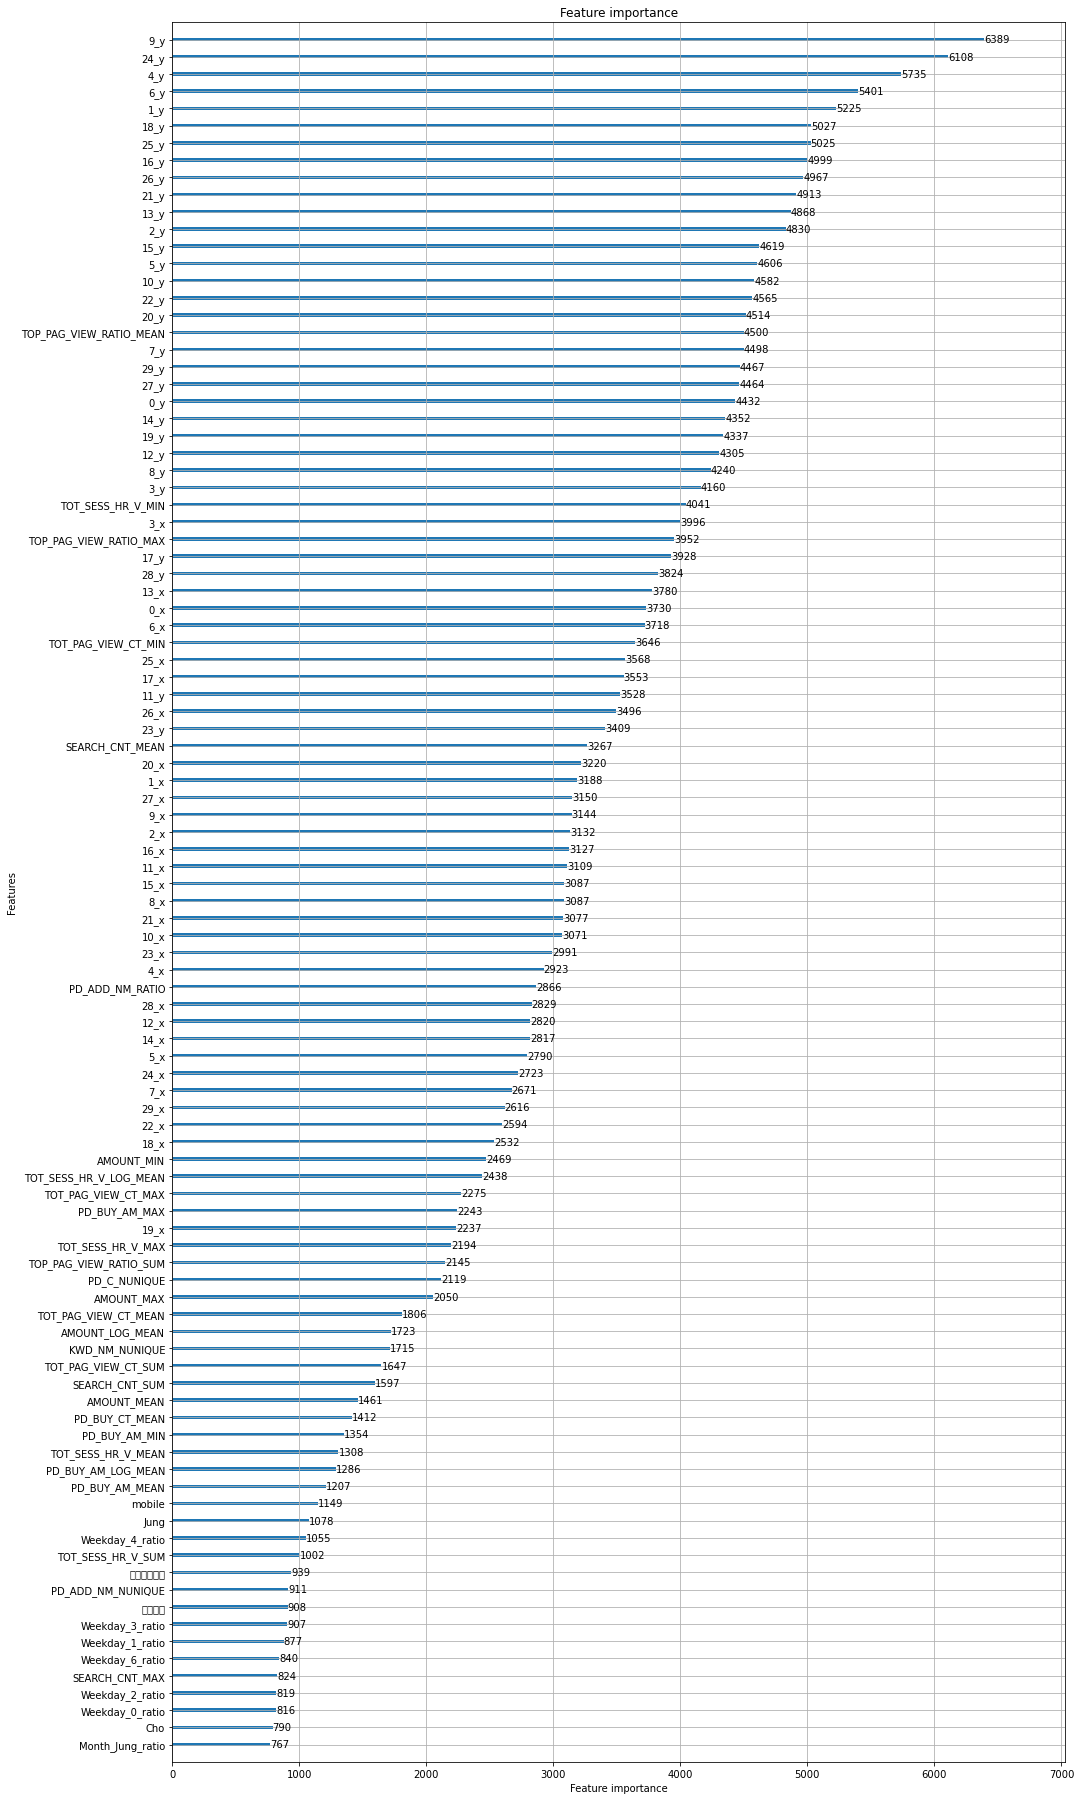

In [84]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

### oof 

In [97]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(data, data_te, nfolds=5):
    ftr_app = data.drop(['CLNT_ID', 'LABEL'], axis=1)
    target_app = data['LABEL']

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr_app.shape[0], 6))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((data_te.shape[0], 6))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr_app)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x  = ftr_app.iloc[train_idx, :]
        train_y = target_app.iloc[train_idx]
        valid_x = ftr_app.iloc[valid_idx, :]
        valid_y = target_app.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(data_te, num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [98]:
clf, test_preds = train_apps_all_with_oof(data, data_te, nfolds=5)

##### iteration  0  시작
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 1.17295	valid_1's multi_logloss: 1.20282
[400]	training's multi_logloss: 1.12147	valid_1's multi_logloss: 1.17762
[600]	training's multi_logloss: 1.08915	valid_1's multi_logloss: 1.16911
[800]	training's multi_logloss: 1.0637	valid_1's multi_logloss: 1.16542
[1000]	training's multi_logloss: 1.042	valid_1's multi_logloss: 1.16359
[1200]	training's multi_logloss: 1.02256	valid_1's multi_logloss: 1.16261
[1400]	training's multi_logloss: 1.00437	valid_1's multi_logloss: 1.16227
[1600]	training's multi_logloss: 0.987075	valid_1's multi_logloss: 1.1621
[1800]	training's multi_logloss: 0.970607	valid_1's multi_logloss: 1.16209
Early stopping, best iteration is:
[1732]	training's multi_logloss: 0.976115	valid_1's multi_logloss: 1.16204
##### iteration  1  시작
[LightGBM

In [100]:
test_preds = pd.DataFrame(test_preds)
result = pd.concat([cust_te.CLNT_ID, test_preds], axis=1)
result.columns = ['CLNT_ID','F20','F30','F40','M20','M30','M40']
result.to_csv('oof.csv',index=False)